## Import Modules

In [36]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline



## Load the Dataset

In [37]:
folder_path = '/kaggle/input/utkface-new/UTKFace'

In [38]:
age=[]
gender=[]
img_path=[]

for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))
    gender.append(int(file.split('_')[1]))
    img_path.append(file)

In [39]:
df=pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [40]:
df.shape

(23708, 3)

In [41]:
df.head()

,age,gender,img
0,26,0,26_0_2_20170104023102422.jpg.chip.jpg
1,22,1,22_1_1_20170112233644761.jpg.chip.jpg
2,21,1,21_1_3_20170105003215901.jpg.chip.jpg
3,28,0,28_0_0_20170117180555824.jpg.chip.jpg
4,17,1,17_1_4_20170103222931966.jpg.chip.jpg


In [46]:
train_df=df.sample(frac=1,random_state=0).iloc[:18967]
test_df=df.sample(frac=1,random_state=0).iloc[18967:]

In [47]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                rotation_range=20,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.5,
                                zoom_range=0.1,
                                brightness_range=(0.5,1.5),
                                horizontal_flip=True ,
                                vertical_flip=False,
                                fill_mode='nearest'
                                 )
test_datagen=ImageDataGenerator(rescale=1./255)

In [48]:
train_generator=train_datagen.flow_from_dataframe(train_df,
                                                  directory=folder_path,
                                                  x_col='img',
                                                  y_col=['age','gender'],
                                                  target_size=(224,224),
                                                  class_mode='multi_output',
                                                 )

test_generator=test_datagen.flow_from_dataframe(test_df,
                                                  directory=folder_path,
                                                  x_col='img',
                                                  y_col=['age','gender'],
                                                  target_size=(224,224),
                                                  class_mode='multi_output')

Found 18967 validated image filenames.
Found 4741 validated image filenames.


In [49]:
input_shape = (224,224,3)

In [50]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential, Model
# Input layer
inputs = Input(input_shape)

# Convolutional layers
conv1_1 = Conv2D(64, (3, 3), activation='relu')(inputs)
conv1_2 = Conv2D(64, (3, 3), activation='relu')(conv1_1)
maxpool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

conv2_1 = Conv2D(128, (3, 3), activation='relu')(maxpool1)
conv2_2 = Conv2D(128, (3, 3), activation='relu')(conv2_1)
maxpool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

conv3_1 = Conv2D(256, (3, 3), activation='relu')(maxpool2)
conv3_2 = Conv2D(256, (3, 3), activation='relu')(conv3_1)
conv3_3 = Conv2D(256, (3, 3), activation='relu')(conv3_2)
maxpool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

conv4_1 = Conv2D(512, (3, 3), activation='relu')(maxpool3)
conv4_2 = Conv2D(512, (3, 3), activation='relu')(conv4_1)
conv4_3 = Conv2D(512, (3, 3), activation='relu')(conv4_2)
maxpool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

conv5_1 = Conv2D(512, (3, 3), activation='relu')(maxpool4)
conv5_2 = Conv2D(512, (3, 3), activation='relu')(conv5_1)
conv5_3 = Conv2D(512, (3, 3), activation='relu')(conv5_2)
maxpool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

# Flatten layer
flatten = Flatten()(maxpool5)

dense1=Dense(256,activation='relu')(flatten)
dense2=Dense(256,activation='relu')(flatten)

dropout_1 = Dropout(0.3) (dense1)
dropout_2 = Dropout(0.3) (dense2)

output1=Dense(1,activation='sigmoid',name='gender')(dropout_1)
output2=Dense(1,activation='relu',name='age')(dropout_2)

model=Model(inputs=inputs,outputs=[output1,output2])


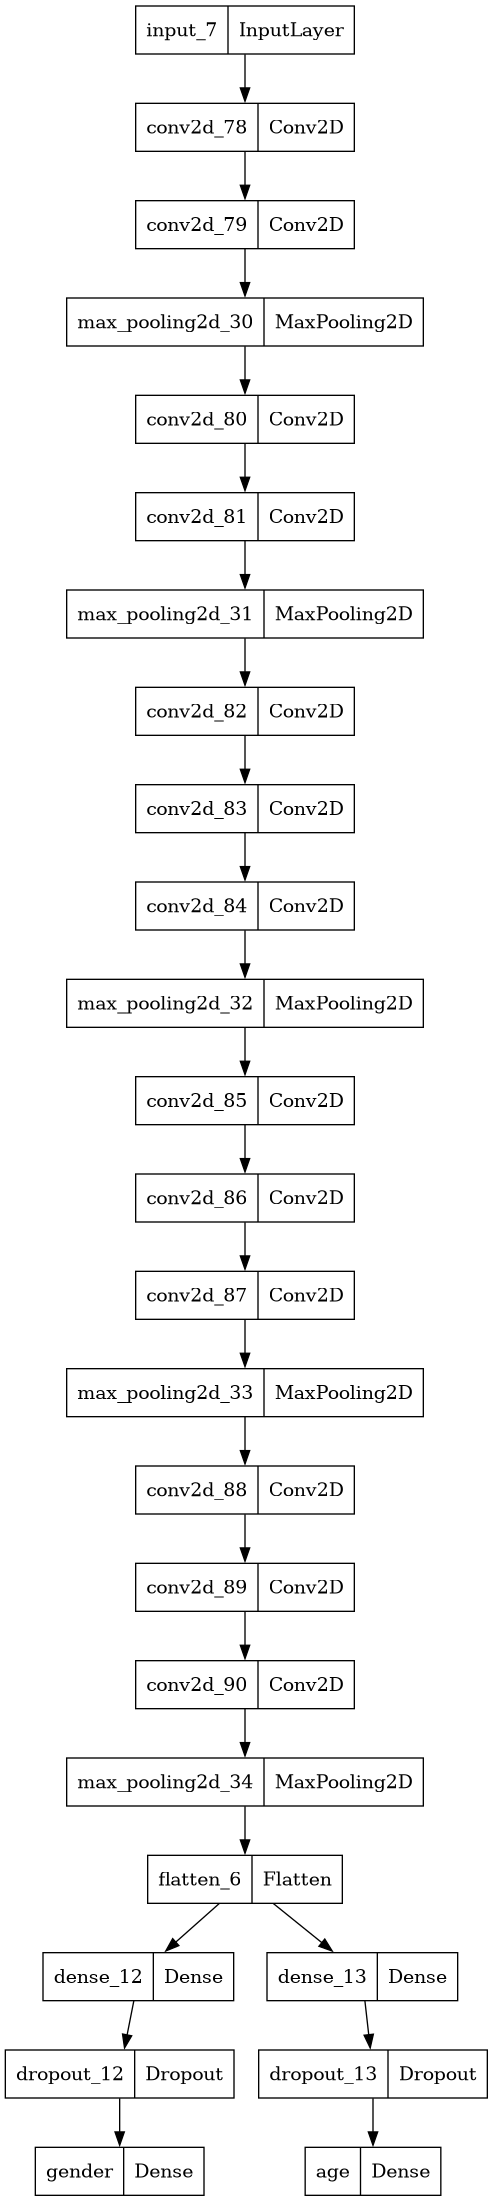

In [51]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [56]:
import wandb
wandb.login(key='5042ff3ca821a65e425d325824bf78eaebc260ed')
wandb.init(
    project='DL Project',
    config={"bs": 12}
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: langvanquy123456. Use `wandb login --relogin` to force relogin


In [58]:
from keras.models import load_model
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlystop = EarlyStopping(min_delta = 0.0005, monitor='loss', patience=3)

In [ ]:
from keras.optimizers import Adam
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0003), loss=['mean_absolute_error', 'binary_crossentropy'],metrics={'age': 'mean_absolute_error'})
history = model.fit(train_generator, batch_size=32, epochs= 50, validation_data= test_generator,callbacks=[WandbMetricsLogger(), earlystop])


Epoch 1/50
593/593 [==============================] - 275s 461ms/step - loss: 39.7346 - gender_loss: 32.3641 - age_loss: 7.3705 - age_mean_absolute_error: 0.4778 - val_loss: 39.3944 - val_gender_loss: 32.0610 - val_age_loss: 7.3334 - val_age_mean_absolute_error: 0.4754
Epoch 2/50
419/593 [====================>.........] - ETA: 1:15 - loss: 39.6904 - gender_loss: 32.3538 - age_loss: 7.3366 - age_mean_absolute_error: 0.4756